In [ ]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import jit, vmap
from pixelgrid import *
from psfmodel import *

In [ ]:
import numpyro
import numpyro.distributions as dist
import matplotlib.pyplot as plt
from jax import random
from jax.config import config
config.update('jax_enable_x64', True)

In [3]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import corner

In [4]:
plt.rcParams['figure.dpi'] = 100

In [5]:
#%% obs grid
Nx, Ny = 30*2, 30*2
pix = PixelGrid(0, Nx, 0, Ny)

#%% true grid (oversample)
oversample_true = 5
spix = PixelGrid(0, Nx, 0, Ny, dx=1./oversample_true, dy=1./oversample_true)

2022-07-17 14:54:16.274153: E external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [6]:
# conversion from supersampled to observed grid
M, N = spix.X.shape
K, L = oversample_true, oversample_true
MK, NL = M // K, N // L
@jit
def super_to_obs(Zsuper):
    return Zsuper[:MK*K, :NL*L].reshape(MK, K, NL, L).sum(axis=(1, 3))

### S matrix

In [53]:
super_to_obs_1d = lambda Zsuper1d: super_to_obs(Zsuper1d.reshape(M,N)).ravel()
super_to_obs_vmap = jit(vmap(super_to_obs_1d, (0), 1))
Zsupeye = np.eye(M*N)
Smat = super_to_obs_vmap(Zsupeye)

In [54]:
truepsffunc = gaussian_psf

In [56]:
Nsource = 10*2
np.random.seed(124)
xcenters = np.random.rand(Nsource)*Nx
ycenters = np.random.rand(Nsource)*Ny
truepsfkws = {"sigma": 1}

In [57]:
def super_image(spix, xcenters, ycenters, psffunc, **kwargs):
    ret = np.zeros_like(spix.X)
    for x, y in zip(xcenters, ycenters):
        sZ = truepsffunc(spix.X, spix.Y, x, y, **kwargs)
        ret += sZ / jnp.sum(sZ)
    return np.array(ret)

def plot2d(Z, pix, xcenters=None, ycenters=None, title=None):
    plt.imshow(Z, origin='lower', extent=(pix.xmin, pix.xmax, pix.ymin, pix.ymax))
    plt.xlabel("x pixel")
    plt.ylabel("y pixel")
    if xcenters is not None:
        for x, y in zip(xcenters, ycenters):
            plt.axvline(x=x, color='gray', lw=1, alpha=0.5)
            plt.axhline(y=y, color='gray', lw=1, alpha=0.5)
    if title is not None:
        plt.title(title)
    plt.colorbar();

In [58]:
Zs = super_image(spix, xcenters, ycenters, truepsffunc, **truepsfkws)

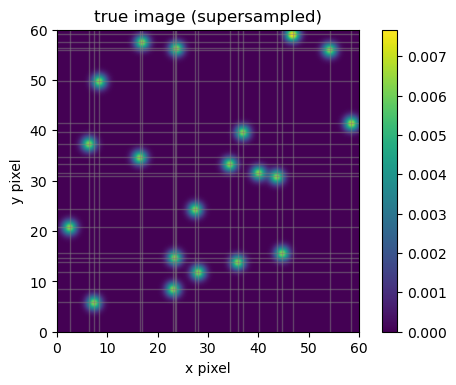

In [59]:
plot2d(Zs, spix, xcenters=xcenters, ycenters=ycenters, title="true image (supersampled)")

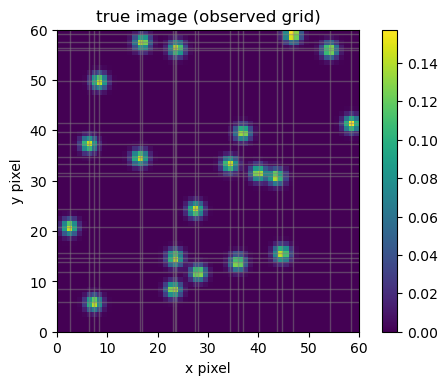

In [60]:
Z = super_to_obs(Zs)
Z_using_mat = jnp.dot(Smat,Zs.ravel()).reshape(Nx,Ny)
plot2d(Z, pix, xcenters=xcenters, ycenters=ycenters, title="true image (observed grid)")

In [61]:
print (np.max(np.abs(Z_using_mat-Z)))

5.551115123125783e-17


In [62]:
np.random.seed(123)
sigmaerr = 2e-3
Zerr = np.random.randn(*np.shape(Z))*sigmaerr
Zobs = Z + Zerr

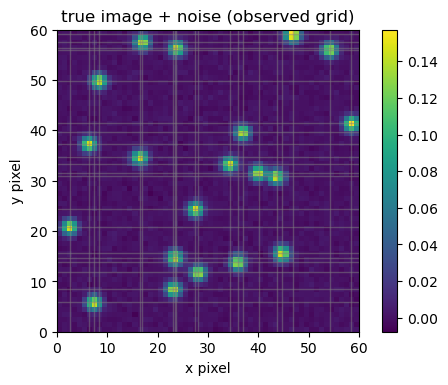

In [63]:
plot2d(Zobs, pix, xcenters=xcenters, ycenters=ycenters, title="true image + noise (observed grid)")

In [64]:
# define supersampled ePSF
xext, yext = 10., 10.
dx, dy = 1., 1.
xext, yext = 7., 7.
dx, dy = 1./3., 1./3.
gpsf = GridPSFModel(xext, yext, dx, dy)
gpsfvalues = vmap(gpsf.psfvalues, (None,None,0,0,None), 0)
gpsfvalues1d = vmap(gpsf.psfvalues1d, (None,None,None,None,0), 1)

PSF grid shape: (21, 21)


In [65]:
trans_matrix = vmap(gpsfvalues1d, (None,None,0,0,None), 0)
paramseye = np.eye(gpsf.Nparams)

In [66]:
f_mean = 1./(gpsf.Nparams*gpsf.ds)

In [67]:
parr = jnp.ones(gpsf.Nparams) * f_mean

In [68]:
jnp.sum(trans_matrix(spix.X, spix.Y, xcenters, ycenters, paramseye)@parr, axis=1)*spix.ds

DeviceArray([1.        , 1.        , 1.        , 1.        , 1.        ,
             1.        , 1.        , 1.        , 0.85153247, 0.63441573,
             1.        , 1.        , 1.        , 0.71440546, 1.        ,
             1.        , 0.86127682, 1.        , 1.        , 1.        ],            dtype=float64)

In [69]:
width = 2.
shift = 0.

In [70]:
def gpkernel(gpsf, lenx, leny, lna):
    dx = gpsf.X1d[:,None] - gpsf.X1d[None,:]
    dy = gpsf.Y1d[:,None] - gpsf.Y1d[None,:]
    dx2 = jnp.power(dx / lenx, 2.0)
    dy2 = jnp.power(dy / leny, 2.0)
    cov = jnp.exp(2*lna) * jnp.exp(-0.5*dx2-0.5*dy2)
    return cov

In [71]:
Ns = Nsource
def params_to_dict(params):
    dic = {}
    c = params[:Ns]
    xc = jnp.r_[xcenters[0], params[Ns:Ns+Ns-1]]
    yc = jnp.r_[ycenters[0], params[2*Ns-1:3*Ns-2]]
    lnlenx, lnleny, lna = jnp.array(params[-3:])
    lenx, leny = jnp.exp(lnlenx), jnp.exp(lnleny)
    dic['c'] = np.array(c)
    dic['xcenters'] = np.array(xc)
    dic['ycenters'] = np.array(yc)
    dic['lnlenx'] = float(lnlenx)
    dic['lnleny']= float(lnleny)
    dic['lna'] = float(lna)
    return dic

In [72]:
def gpsfloglike(params, Z, sigmaerr, gpsf):

    carr = jnp.r_[1., params[1:Ns]]
    xarr = jnp.r_[xcenters[0], params[Ns:Ns+Ns-1]]
    yarr = jnp.r_[ycenters[0], params[2*Ns-1:3*Ns-2]]
    lnlenx, lnleny, lna = jnp.array(params[-3:])
    lenx, leny = jnp.exp(lnlenx), jnp.exp(lnleny)

    fcov = gpkernel(gpsf, lenx, leny, lna)
    
    Amat = jnp.sum(carr[:,None,None] * trans_matrix(spix.X, spix.Y, xarr, yarr, paramseye), axis=0)
    SA = jnp.dot(Smat, Amat)
    cov = jnp.dot(SA, jnp.dot(fcov, SA.T)) + sigmaerr**2 * jnp.eye(pix.Nx*pix.Ny)
    mv = dist.MultivariateNormal(loc=0., covariance_matrix=cov)
    
    return mv.log_prob(Z.ravel())

In [73]:
def loglikelihood(params, Z1d, sigmaerr):
    #c = params[:Ns]
    c = jnp.r_[1, params[1:Ns]]
    xc = jnp.r_[xcenters[0], params[Ns:Ns+Ns-1]]
    yc = jnp.r_[ycenters[0], params[2*Ns-1:3*Ns-2]]
    lnlenx, lnleny, lna = jnp.array(params[-3:])
    #lnlenx, lnleny, lna = 1., 1., -3.
    lenx, leny = jnp.exp(lnlenx), jnp.exp(lnleny)
    
    dx = gpsf.X1d[:,None] - gpsf.X1d[None,:]
    dy = gpsf.Y1d[:,None] - gpsf.Y1d[None,:]
    dx2 = jnp.power(dx / lenx, 2.0)
    dy2 = jnp.power(dy / leny, 2.0)
    kernel = jnp.exp(2*lna) * jnp.exp(-0.5*dx2-0.5*dy2)

    Amat = c[:,None,None] * trans_matrix(spix.X, spix.Y, xc, yc, paramseye)
    #Amat = jnp.sum(Amat, axis=0)
    Amat = jnp.dot(Smat, jnp.sum(Amat, axis=0))

    cov = jnp.dot(Amat, jnp.dot(kernel, Amat.T))
    cov += sigmaerr**2 * jnp.eye(pix.Nx*pix.Ny)
    
    SinvZ = jnp.linalg.solve(cov, Z1d)

    #return -0.5 * len(Z1d) * jnp.linalg.slogdet(cov)[1] - 0.5 * jnp.dot(Z1d.T, SinvZ)
    return -0.5 * jnp.linalg.slogdet(cov)[1] - 0.5 * jnp.dot(Z1d.T, SinvZ) - 0.5 * len(Z1d) * jnp.log(2*jnp.pi)

#objective = lambda p: -loglikelihood(p, Zobs.ravel(), sigmaerr)
objective = lambda p: -gpsfloglike(p, Zobs, sigmaerr, gpsf)

In [74]:
width = 2.
shift = 0.
params = np.array([1.]*Ns + list(xcenters[1:]-1.*0.5) + list(ycenters[1:]+1.*0.5) + [0, 0, -5])
params_lower = [0]*Ns + list(xcenters[1:]-width) + list(ycenters[1:]-width) + [-5+3, -5+3, -10.]
params_upper = [10]*Ns + list(xcenters[1:]+width) + list(ycenters[1:]+width) + [2., 2., 0.]
bounds = (params_lower, params_upper)

In [75]:
import jaxopt
method = "TNC"
#method = "Nelder-Mead"
solver = jaxopt.ScipyBoundedMinimize(fun=objective, method=method)#, options={'gtol': 1e-100, 'maxfun': 10000})

In [78]:
%time loglikelihood(params, Zobs.ravel(), sigmaerr)

CPU times: user 114 ms, sys: 54.6 ms, total: 168 ms
Wall time: 149 ms


DeviceArray(14725.6740506, dtype=float64)

In [79]:
%time gpsfloglike(params, Zobs, sigmaerr, gpsf)

CPU times: user 29.6 ms, sys: 6.86 ms, total: 36.4 ms
Wall time: 21.5 ms


DeviceArray(14725.6740506, dtype=float64)

In [80]:
def show_res(res):
    print ()
    print (res)
    popt, state = res
    pdict = params_to_dict(popt)
    xmean = pdict['xcenters'][1:]
    ymean = pdict['ycenters'][1:]
    dx = xmean - xcenters[1:]
    dy = ymean - ycenters[1:]
    print ("# dx = %.3f +/- %.3f"%(np.mean(dx),np.std(dx)))
    print ("# dy = %.3f +/- %.3f"%(np.mean(dy),np.std(dy)))
    return popt, pdict

In [ ]:
%%time
res = solver.run(params, bounds=bounds)
popt, pdict = show_res(res)

In [44]:
for i in range(3):
    res = solver.run(popt, bounds=bounds)
    popt, pdict = show_res(res)

OptStep(params=DeviceArray([ 1.        ,  1.00744868,  0.99190245,  1.26611649,
              0.99650225,  0.99468701,  1.11686833,  0.99924446,
              0.99745944,  0.98555935, 22.36354598, 17.16597989,
             13.75341474, 11.52784411,  8.21621993, 20.02890306,
             11.86130008,  8.45519736, 23.40559265,  3.67435804,
             11.67524232, 29.23591589, 14.02329655,  4.20742314,
              1.22623439, 21.82347946, 18.448158  , 27.07414167,
              0.30551586,  0.24976195, -8.09246961], dtype=float64), state=ScipyMinimizeInfo(fun_val=DeviceArray(-4204.19955262, dtype=float64), success=True, status=1, iter_num=1))
# dx = -0.001 +/- 0.007
# dy = -0.014 +/- 0.010
OptStep(params=DeviceArray([ 1.        ,  1.00744903,  0.99190267,  1.26611681,
              0.99650255,  0.99468733,  1.11686866,  0.99924479,
              0.99745974,  0.9855597 , 22.36354621, 17.16598014,
             13.75341533, 11.52784424,  8.21622013, 20.02890315,
             11.86130016,

In [45]:
for k in pdict.keys():
    print ("%s\t%s"%(k, pdict[k]))

c	[1.         1.00744876 0.99190249 1.26611653 0.99650231 0.99468707
 1.1168684  0.99924453 0.9974595  0.98555942]
xcenters	[ 3.18194718 22.36354641 17.16598037 13.75341519 11.52784451  8.21622037
 20.02890344 11.86130042  8.45519762 23.40559307]
ycenters	[17.97282491  3.67435791 11.67524224 29.2359157  14.02329632  4.20742296
  1.22623419 21.82347937 18.44815788 27.07414153]
lnlenx	0.3055158119008804
lnleny	0.24976165072209347
lna	-8.092469082720953


In [46]:
xmean = pdict['xcenters'][1:]
ymean = pdict['ycenters'][1:]
xstd, ystd = 0*xmean, 0*ymean
dmax = np.r_[np.abs(xmean-xcenters[1:]-shift)+np.abs(xstd), np.abs(ymean-ycenters[1:]-shift)+np.abs(ystd)].max()
print (np.mean(xmean-xcenters[1:]), np.mean(ymean-ycenters[1:]))

-0.0012824015916918323 -0.01357747302518613


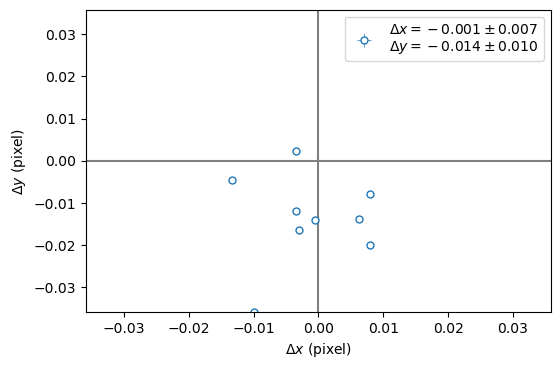

In [47]:
plt.figure()
plt.xlabel("$\Delta x$ (pixel)")
plt.ylabel("$\Delta y$ (pixel)")
plt.xlim(-dmax, dmax)
plt.ylim(-dmax, dmax)
plt.axvline(x=0, color='gray', zorder=-1000)
plt.axhline(y=0, color='gray', zorder=-1000)
dx = xmean-xcenters[1:]-shift
dy = ymean-ycenters[1:]-shift
plt.errorbar(dx, dy, xerr=xstd, yerr=ystd, fmt='o', mfc='white', lw=0.5, markersize=5,
            label="$\Delta x=%.3f\pm%.3f$\n$\Delta y=%.3f\pm%.3f$"%(np.mean(dx), np.std(dx), np.mean(dy), np.std(dy)))
plt.legend(loc='best', bbox_to_anchor=(1,1))